In [1]:
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import shutil
import math

In [2]:
with open('./PedTables/AllPeds.p', 'rb') as fp:
    AllPeds = pickle.load(fp)

In [3]:
PedIDs = list(AllPeds.keys())
len(PedIDs)

23056

In [97]:
def BothSides(df,axis):       #ped appears on both side of the car axis?
    ped = list(df[axis])
    if np.sign(max(ped)*min(ped)) == 1:
        both = 0
    else:
        both = 1
    return both

def FrontCross(df):     #ped is in front of car when crossing?
    zero = min((df['y']), key = abs) #closest y to zero (SDC y is 0)
    dist = df[df['y']==zero]['x'].values[0]
    if abs(zero)<1:
        if (dist>2) & (dist<50):
            front = 1
        else:
            front = 0
    else:
        front = 0
    return front

# checks if the pedestrian moves at least dst meters
def MinWalk(df,dst): 
    #xVeh = df['x_GF_SDC']
    #yVeh = df['y_GF_SDC']
    xPed =  df['px_GF']
    yPed =  df['py_GF']
    X = xPed[len(xPed)-1] - xPed[0]
    Y = yPed[len(yPed)-1] - yPed[0]
    walked = np.sqrt(X**2+Y**2)
    if walked < dst:
        walking = 0
    else:
        walking = 1
    return walking

# checks if the pedestrian moves in front of the car
def MoveCenter(df): 
    zero = min((df['y']), key = abs) #closest y to zero (SDC y is 0)
    ID = df[df['y'] == zero].index[0]
    SxPed = df.iloc[ID]['Speed x']
    SyPed = df.iloc[ID]['Speed y']
    walked = np.sqrt(SxPed**2+SyPed**2)
    
    if walked < 0.5:  #m/s
        walking = 0
    else:
        walking = 1
        
    return walking

#angle between car and ped when ped is located in front of the car
def angle(df,thrsh):     
    zero = min((df['y']), key = abs) #closest y to zero (SDC y is 0)
    IDmin = df[df['y'] == zero].index[0]
    #x0Ped = df.iloc[IDmin]['px_GF']
    #y0Ped = df.iloc[IDmin]['py_GF']
    #x0Veh = df.iloc[IDmin]['x_GF_SDC']
    #y0Veh = df.iloc[IDmin]['y_GF_SDC']
    
    ID1 = IDmin - 5
    ID2 = IDmin + 5
    if ID2>(df.shape[0]-1):
        ID2 = df.shape[0]-1
    x1Ped = df.iloc[ID1]['px_GF']
    y1Ped = df.iloc[ID1]['py_GF']
    x1Veh = df.iloc[ID1]['x_GF_SDC']
    y1Veh = df.iloc[ID1]['y_GF_SDC']
    
    x2Ped = df.iloc[ID2]['px_GF']
    y2Ped = df.iloc[ID2]['py_GF']
    x2Veh = df.iloc[ID2]['x_GF_SDC']
    y2Veh = df.iloc[ID2]['y_GF_SDC']
    
    deltaYPed = y2Ped - y1Ped
    deltaXPed = x2Ped - x1Ped
    anglePed = math.atan2(deltaYPed,deltaXPed)*180/math.pi
    
    deltaYVeh = y2Veh - y1Veh
    deltaXVeh = x2Veh - x1Veh
    angleVeh = math.atan2(deltaYVeh,deltaXVeh)*180/math.pi
    ang = abs(anglePed-angleVeh)
    if (ang<(90+thrsh) and ang>(90-thrsh)) or (ang<(270+thrsh) and ang>(270-thrsh)):
        jay = 1
    else:
        jay = 0
    return (jay,ang)

#Change in vehiclles direction 
def angleCar(df,thrsh):     
    Size = df.shape[0]-1
    #x0Ped = df.iloc[IDmin]['px_GF']
    #y0Ped = df.iloc[IDmin]['py_GF']
    #x0Veh = df.iloc[IDmin]['x_GF_SDC']
    #y0Veh = df.iloc[IDmin]['y_GF_SDC']
    ID0 = 0
    IDmax = Size
    IDmid = int(IDmax/2)

    x0 = df.iloc[ID0]['x_GF_SDC']
    y0 = df.iloc[ID0]['y_GF_SDC']
    
    xmax = df.iloc[IDmax]['x_GF_SDC']
    ymax = df.iloc[IDmax]['y_GF_SDC']
    
    xmid = df.iloc[IDmid]['x_GF_SDC']
    ymid = df.iloc[IDmid]['y_GF_SDC']
    
    deltaY0 = ymid - y0
    deltaX0 = xmid - x0
    angle0 = math.atan2(deltaY0,deltaX0)*180/math.pi
    
    deltaY1 = ymax - ymid
    deltaX1 = xmax - xmid
    angle1 = math.atan2(deltaY1,deltaX1)*180/math.pi
    
    ang = abs(angle1-angle0)
    
    if (ang<thrsh):
        straight = 1
    else:
        straight = 0
    return (straight,ang)

#check if the ped and SDC cross the same point( with tolerance)
def ifintersect(df,tol):
    
    array1 = np.array([[x, y] for x, y in zip(df['x_GF_SDC'], df['y_GF_SDC'])])

    array2 = np.array([[x, y] for x, y in zip(df['px_GF'], df['py_GF'])])

    output = np.empty((0,2))
    for i0, i1 in itertools.product(np.arange(array1.shape[0]),
                                    np.arange(array2.shape[0])):
        if np.all(np.isclose(array1[i0], array2[i1], atol=tol)):
             output = np.concatenate((output, [array2[i1]]), axis=0)
    if len(output>0):
        close = 1
    else:
        close = 0
    return close

In [41]:
### F1: Filter 1: ped is detected in front of the car
### F2: Filter 2: ped is seen on left and right side of the car
### F3: Filter 3: ped is moving in the frame
### F4: Filter 4: ped is moving when in front of the car
### F5: Filter 5: ped and vehcile angle is below a threshold
### F6: Filter 6: vehcile change in direction angle is below a threshold
### F7: Filter 7: ped and vehicle have intersecting trajectories, path a same point

In [98]:
F1 = {k : v for k, v in AllPeds.items() if FrontCross(v) == 1} #ped is detected in front of the car
F1IDs = list(F1.keys())

len(F1IDs)

1182

In [99]:
F12 = {k : v for k, v in F1.items() if BothSides(v,'x') == 1} #left and right
F12IDs = list(F12.keys())

len(F12IDs)

280

In [100]:
F123 = {k : v for k, v in F12.items() if MinWalk(v,1.5) == 1} #Pedestrian is not stationary
F123IDs = list(F123.keys())

len(F123IDs)

211

In [101]:
F1234 = {k : v for k, v in F123.items() if MoveCenter(v) == 1} #Pedestrian is not stationary in y=0
F1234IDs = list(F1234.keys())

len(F1234IDs)

180

In [102]:
F12345 = {k : v for k, v in F1234.items() if angle(v,60)[0] == 1} #Pedestrian and veh angle
F12345IDs = list(F12345.keys())

len(F12345IDs)

117

In [91]:
F123456 = {k : v for k, v in F12345.items() if angleCar(v,60)[0] == 1} #veh direction changes
F123456IDs = list(F123456.keys())

len(F123456IDs)

55

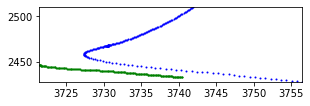

In [95]:
dfs = F123456
dfID = F123456IDs
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(538)

instance = 30
xVeh = dfs[dfID[instance]]['x_GF_SDC']
yVeh = dfs[dfID[instance]]['y_GF_SDC']
xPed =  dfs[dfID[instance]]['px_GF']
yPed =  dfs[dfID[instance]]['py_GF']
Xlim = (min(min(xVeh),min(xPed)), max(max(xPed),max(xVeh)))
Ylim = (min(min(yVeh),min(yPed)), max(max(yPed),max(yVeh)))

ax.set(xlim = Xlim, ylim = Ylim)
ax.scatter(xPed,yPed ,s=1, c='g', label='Pedestrian')

ax.scatter(xVeh,yVeh ,s=1, c='b', label='LIDAR Top')
    
plt.show()

In [96]:
zero = min( dfs[dfID[instance]]['y'],key = abs)
dist =  dfs[dfID[instance]][ dfs[dfID[instance]]['y']==zero]['x'].values[0]
ID =  dfs[dfID[instance]]['Segment ID'][0]
X = max( dfs[dfID[instance]]['px_GF']) - min( dfs[dfID[instance]]['px_GF'])
Y = max( dfs[dfID[instance]]['py_GF']) - min( dfs[dfID[instance]]['py_GF'])
ang = angle(dfs[dfID[instance]],45)

walked = np.sqrt(X**2+Y**2)
print (f'Distance in x axis: {dist}\nDistance in y axis: {zero}'
       f'\nPedestrian angle: {ang[0]}'
       f'\angle: {ang[1]}'
       f'\nPedestrian distance covered: {walked}'
       f'\nFile ID: {ID}')

Distance in x axis: 17.31110033625191
Distance in y axis: 0.355604008274895
Pedestrian angle: 1ngle: 242.4615272130198
Pedestrian distance covered: 23.463187862749418
File ID: 0002_11126313430116606120_1439_990_1459_990


In [295]:
# # get unique segment files of intersected trajectories and copy to system

# segmentID = pd.Series()
# for i in range(len(CCrossIDs)):
#     ID = pd.Series(CarCrossPeds[CCrossIDs[i]]['Segment ID'][0])
#     segmentID = segmentID.append(ID)
    

# len(segmentID.unique())

# src_folder = '/media/arash/My Book/waymo'#'./waymo-od/data'
# dest_folder = '/home/arash/PedVid/waymo-od/IntersectingData'

# def scan(folder,fileID,lst):   #get all file names      
#     for path,dirs,files in os.walk(folder):
#         for f in files:
#             if fileID[5:] in f:
#                 lst.append(os.path.join(path,f))
#     return(lst)

# lst = []
# for fileID in segmentID.unique():
#     lst = scan(src_folder,fileID,lst)
    
    

# for file_name in lst:
#     shutil.copy(file_name, dest_folder)